# Bayes Factor

In [ ]:
import os
import sys
import typing as t
import numpy as np
import pandas as pd
import sklearn.metrics as skmetrics
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from my_code.plotting import graph_theme, ibm
from my_code.metrics import bayes_factor_score
from my_code.utils import load_nested_dict_to_pandas, cut_end_points_groupby

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [3]:
DATASETS = [
    "fake_data",
    "breast_cancer",
    "uti",
    "california_housing",
    "heart_disease",
    "wine_quality"
]

DATASETS_TASK = {
    "fake_data": "regression",
    "breast_cancer": "classification",
    "uti": "classification",
    "california_housing": "regression",
    "heart_disease": "classification",
    "wine_quality": "classification",
    r"$y = 2 x_1 - x_2 + x_3$": "regression",
    "Breast Cancer": "classification",  
    "UTI": "classification",
    "California Housing": "regression",
    "Heart Disease": "classification",
    "Wine Quality": "classification",
}


In [4]:
elicitation_results_path = os.path.join(
    "results", "bayes_factor", "elicitation"
)

uninformative_results_path = os.path.join(
    "results", "bayes_factor", "elicitation"
)

icl_results_path = os.path.join(
    "results", "bayes_factor", "icl"
)

In [5]:
elicitation_results_names = [
    f for f in os.listdir(elicitation_results_path)
    if f.endswith(".npz") and "pe" in f
]

uninformative_results_names = [
    f for f in os.listdir(elicitation_results_path)
    if f.endswith(".npz") and "up" in f
]

icl_results_names = [
    f for f in os.listdir(icl_results_path)
    if f.endswith(".npz")
]

In [6]:
def load_results_dict(
    results_path: str,
    results_names: t.List[str],
    dataset: t.List[str],
):
    results_dict = {}
    for results_name in results_names:
        if dataset in results_name:
            results = np.load(
                os.path.join(results_path, results_name),
                allow_pickle=True
            )
            results_dict[results_name] = results

    return results_dict

def load_predictions_targets_and_likelihoods(
    results_dict: t.Dict[str, t.Dict[str, np.lib.npyio.NpzFile]]
):
    
    predictions = [results["predictions"] for results in results_dict.values()]
    targets = [results["y_true"] for results in results_dict.values()]
    log_marginal_likelihood = [
        results["log_marginal_likelihood"] for results in results_dict.values()
    ]

    return predictions, targets, log_marginal_likelihood

In [7]:
method_to_results_paths = {
    "elicitation": elicitation_results_path,
    "uninformative": uninformative_results_path,
    "icl": icl_results_path,
}

method_to_results_names = {
    "elicitation": elicitation_results_names,
    "uninformative": uninformative_results_names,
    "icl": icl_results_names,
}


results_dict = {}

for dataset in DATASETS:
    results_dict[dataset]  = {}
    for method in method_to_results_names.keys():
        results_dict_dataset_method = load_results_dict(
            method_to_results_paths[method],
            method_to_results_names[method],
            dataset,
        )

        (
            predictions, 
            targets, 
            log_marginal_likelihood
        ) = load_predictions_targets_and_likelihoods(
            results_dict_dataset_method
        )

        results_dict[dataset][method] = {
            "predictions": predictions,
            "targets": targets,
            "log_marginal_likelihood": log_marginal_likelihood,
        }

        if DATASETS_TASK[dataset] == "classification":
            results_dict[dataset][method]["metrics_to_plot"] = [
                [
                    skmetrics.accuracy_score(
                        targets[r].ravel(), 
                        (predictions[r][s] > 0.5).ravel()
                    )
                    for s in range(len(predictions[r]))
                ]
                for r in range(len(predictions))
            ]

        elif DATASETS_TASK[dataset] == "regression":
            results_dict[dataset][method]["metrics_to_plot"] = [
                [
                    skmetrics.mean_squared_error(
                        targets[r].ravel(), 
                        predictions[r][s].ravel()
                    )
                    for s in range(len(predictions[r]))
                ]
                for r in range(len(predictions))
            ]


In [8]:
results_df = (
    load_nested_dict_to_pandas(
        results_dict,
        level_names=["dataset", "method"],
    )
    [['dataset', 'method', 'log_marginal_likelihood', 'metrics_to_plot']]
    .explode(
        ["log_marginal_likelihood", "metrics_to_plot"], 
        ignore_index=True
    )
    .explode(
        ["log_marginal_likelihood", "metrics_to_plot"], 
        ignore_index=True
    )
    .assign(
        marginal_likelihood=lambda df: np.exp(
            df["log_marginal_likelihood"].astype(np.float64).values
        )
    )
    .replace(
        {
            "method":{
                "elicitation": "Elicitation",
                "uninformative": "Uninformative",
                "icl": "ICL",
            },
            "dataset": {
                "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
                "breast_cancer": "Breast Cancer",
                "uti": "UTI",
                "california_housing": "California Housing",
                "heart_disease": "Heart Disease",
                "wine_quality": "Wine Quality",
            }
        }
    )
)
results_df.head()

,dataset,method,log_marginal_likelihood,metrics_to_plot,marginal_likelihood
0,$y = 2 x_1 - x_2 + x_3$,Elicitation,-128.195067,5.127803,2.116362e-56
1,$y = 2 x_1 - x_2 + x_3$,Elicitation,-76.217662,3.048706,7.926656e-34
2,$y = 2 x_1 - x_2 + x_3$,Elicitation,-22.897467,0.915899,1.136990e-10
3,$y = 2 x_1 - x_2 + x_3$,Elicitation,-47.948672,1.917947,1.500224e-21
4,$y = 2 x_1 - x_2 + x_3$,Elicitation,-298.268769,11.930751,2.907499e-130


In [9]:
results_df = (
    load_nested_dict_to_pandas(
        results_dict,
        level_names=["dataset", "method"],
    )
    [['dataset', 'method', 'log_marginal_likelihood', 'metrics_to_plot']]
    .explode(
        ["log_marginal_likelihood", "metrics_to_plot"], 
        ignore_index=True
    )
    .groupby(["dataset", "method"])
    [["log_marginal_likelihood", "metrics_to_plot"]]
    .apply(
        lambda df: df.assign(split = np.arange(len(df)))
    )
    .reset_index()
    .drop(columns=["level_2"])
    .explode(
        ["log_marginal_likelihood", "metrics_to_plot"], 
        ignore_index=True
    )
    .assign(
        log_marginal_likelihood=lambda df: df["log_marginal_likelihood"].astype(np.float64),
    )
    .assign(
        marginal_likelihood=lambda df: np.exp(
            df["log_marginal_likelihood"].values
        )
    )
    .replace(
        {
            "method":{
                "elicitation": "Elicitation",
                "uninformative": "Uninformative",
                "icl": "ICL",
            },
            "dataset": {
                "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
                "breast_cancer": "Breast Cancer",
                "uti": "UTI",
                "california_housing": "California Housing",
                "heart_disease": "Heart Disease",
                "wine_quality": "Wine Quality",
            }
        }
    )
)
results_df.head()

,dataset,method,log_marginal_likelihood,metrics_to_plot,split,marginal_likelihood
0,Breast Cancer,Elicitation,-0.324347,0.88,0,0.722999
1,Breast Cancer,Elicitation,-0.593340,0.68,0,0.552479
2,Breast Cancer,Elicitation,-0.366054,0.84,0,0.693465
3,Breast Cancer,Elicitation,-0.366940,0.8,0,0.692851
4,Breast Cancer,Elicitation,-0.273251,0.88,0,0.760902


In [10]:
bayes_factor = (
    results_df
    .groupby(["dataset", "method", "split"])
    ['log_marginal_likelihood']
    .mean()
    .unstack("method")
    [["Elicitation", "ICL"]]
    .assign(
        **{
            "Bayes Factor": lambda df: df.apply(
                lambda x: bayes_factor_score(
                    x["Elicitation"], x["ICL"]
                ),
                axis=1
            )
        }
    )
    ['Bayes Factor']
    .reset_index()
    .groupby("dataset")
    ["Bayes Factor"]
    .apply(list)
    .to_dict()
)
bayes_factor

{'$y = 2 x_1 - x_2 + x_3$': [0.0, 0.0, 0.0, 0.0, 0.0],
 'Breast Cancer': [2.0587917978867845,
  3.752639596104742,
  1.4983656481238932,
  2.9697957512232476,
  2.9271898756259405],
 'California Housing': [inf, inf, 0.0, inf, inf],
 'Heart Disease': [0.691976165423337,
  0.6528002462500473,
  0.6823158506706994,
  0.6602260442058185,
  0.7586635101563659],
 'UTI': [nan, nan, nan, nan, nan],
 'Wine Quality': [1.1687337672954718,
  1.39158935950548,
  1.9968872478080937,
  1.036049818559258,
  1.2842817212309943]}

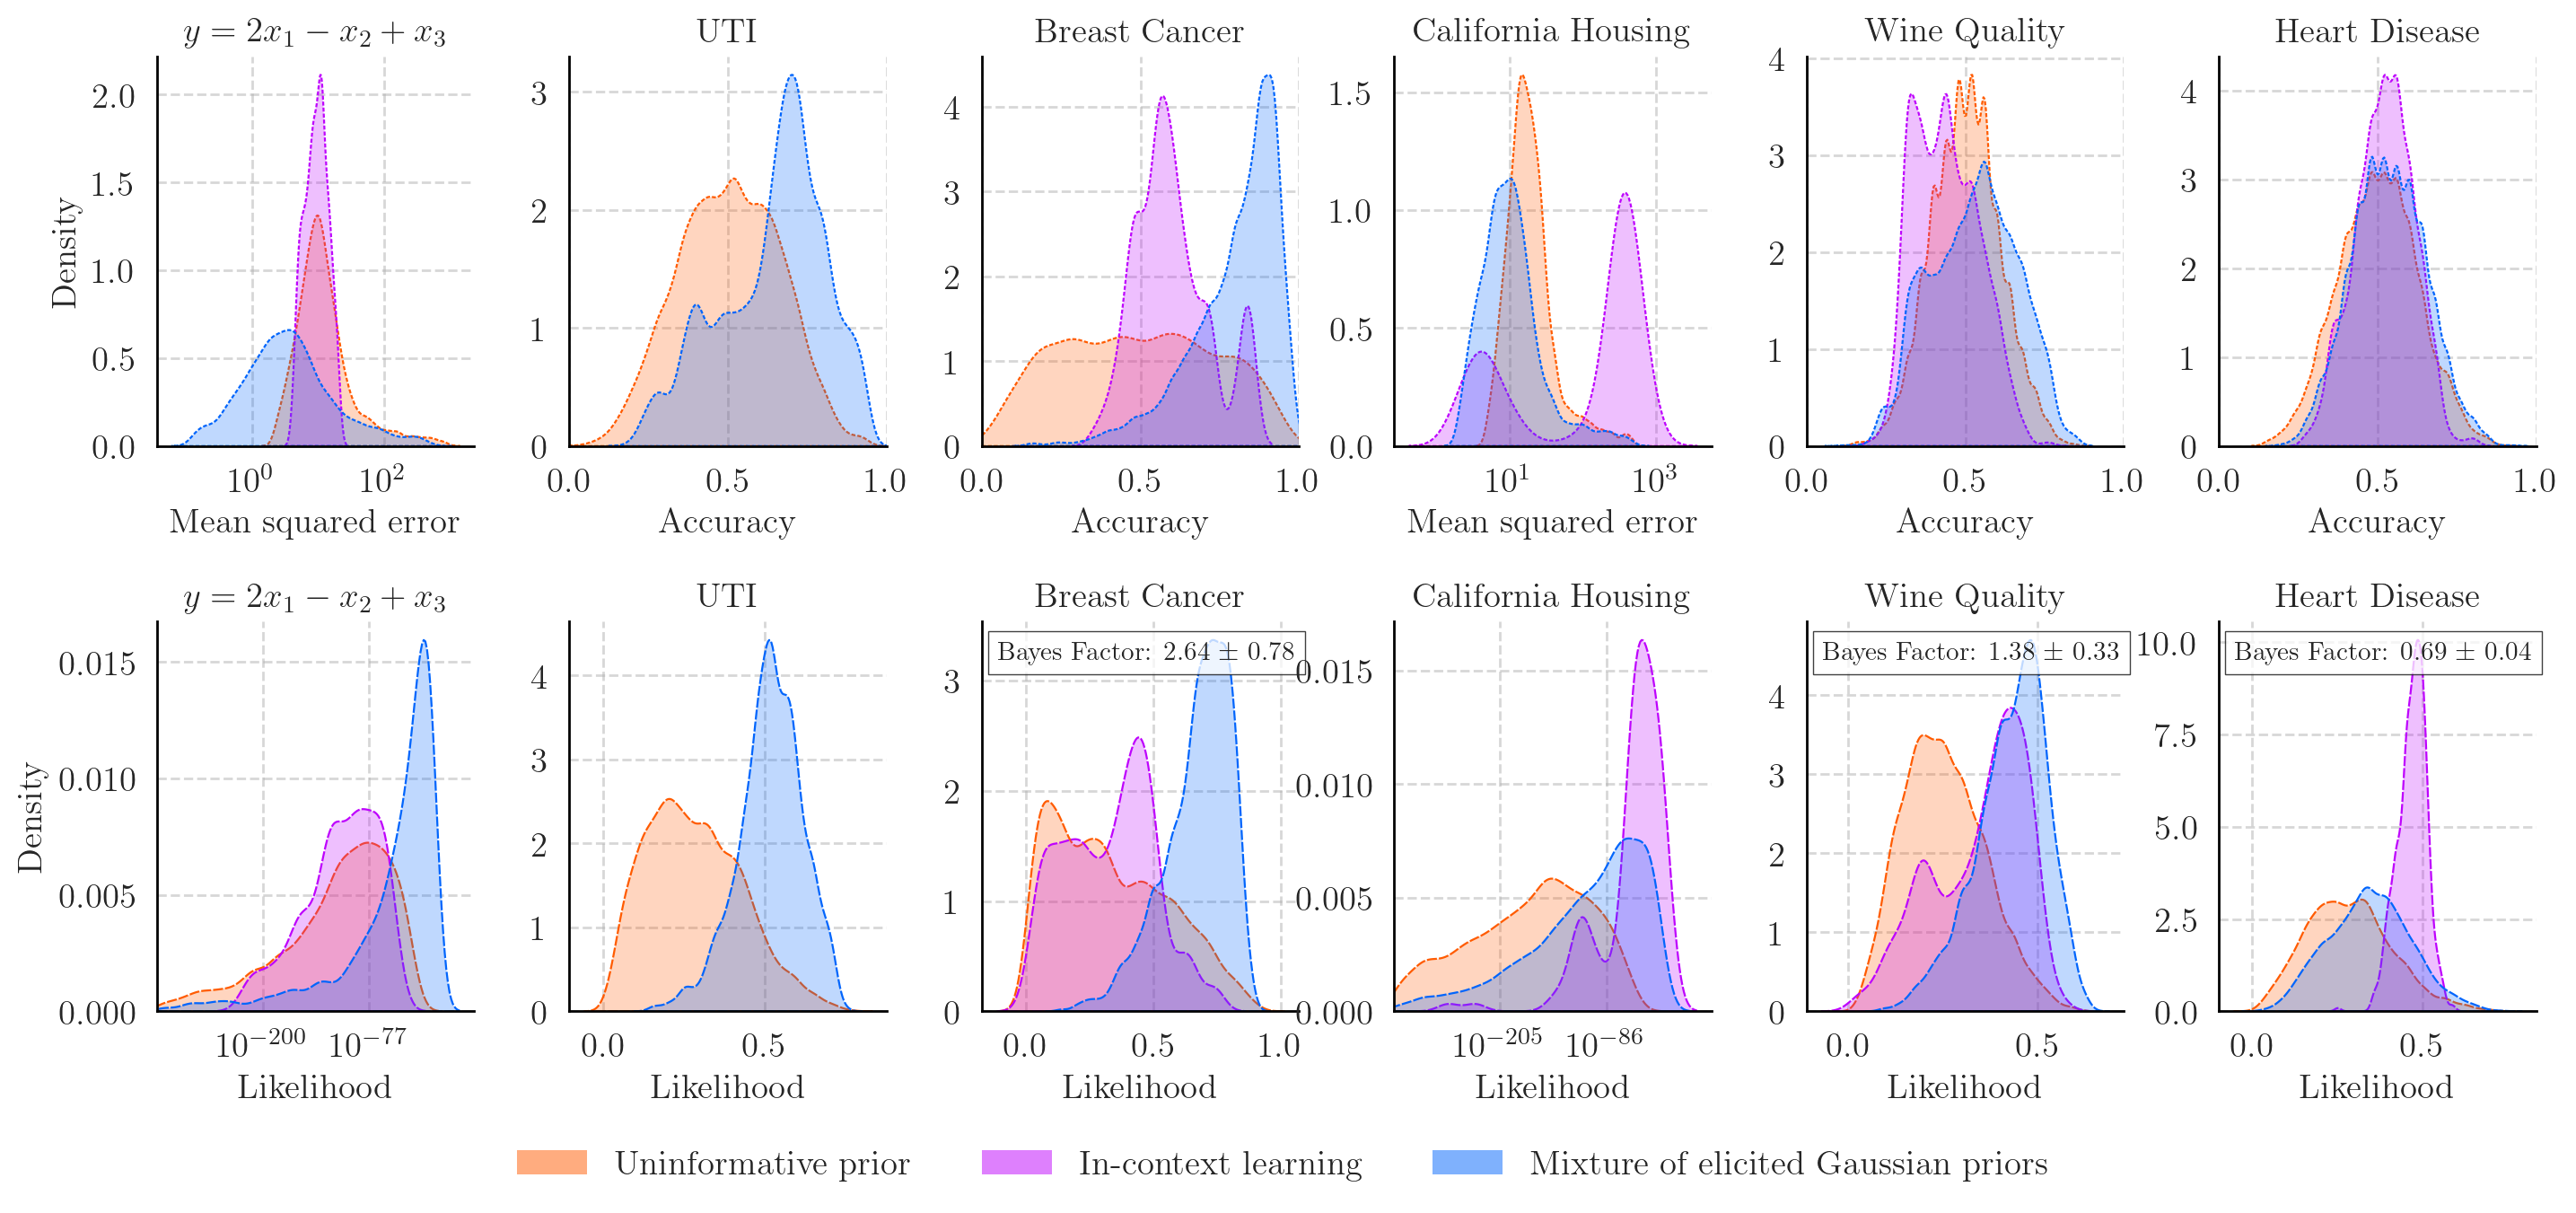

In [ ]:
plt.close()

n_rows = 2
n_cols = 6 
n_methods = results_df["method"].nunique()

hist_config = dict(
    alpha=0.4,
    edgecolor="black",
    linewidth=0.0,
    bins=20,
    kde=True,
    common_norm=False, 
    common_bins=False,
    stat="density",
    line_kws=dict(
        linewidth=2
    ),
)

fontsize = 14

palette = list(sns.color_palette(ibm))

palette_dict = {
    'Elicitation': "xkcd:bright blue", 
    'Uninformative': "xkcd:bright orange",
    'ICL': "xkcd:bright purple"
}

dataset_order = [
    r"$y = 2 x_1 - x_2 + x_3$",
    "UTI",
    "Breast Cancer",
    "California Housing",
    "Wine Quality",
    "Heart Disease",
]

with graph_theme():
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(2*linewidth, 0.75*2*linewidth/1.618)
    )

    results_df = (
        results_df
        .sort_values("method")
        .sort_values(by="dataset", key=lambda x: x.map(dataset_order.index))
    )

    # metric plots on top row
    for nax, (dataset, df) in enumerate(
        results_df.groupby("dataset", sort=False)
    ):
        ax = axes[0, nax]

        if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$"]:
            df = cut_end_points_groupby(
                df=df,
                groupby="method", cut_on="metrics_to_plot",
                lower_percentile=2.5, upper_percentile=97.5
            )

        ax = sns.kdeplot(
            data=df,
            x="metrics_to_plot",
            hue="method",
            ax=ax,
            legend=False,
            palette=palette_dict,
            hue_order=["Elicitation", "ICL", "Uninformative"],
            common_norm=False,
            linestyle=(0, (2, 1)),
            fill=True,
            log_scale=True if DATASETS_TASK[dataset] == "regression" else False,
            bw_adjust=0.75,
        )

        ax.set_title(f"{dataset}", fontsize=fontsize)
        if nax == 0:
            ax.set_ylabel("Density", fontsize=fontsize)
        else:
            ax.set_ylabel("", fontsize=fontsize)

        if DATASETS_TASK[dataset] == "classification":
            ax.set_xlabel("Accuracy", fontsize=fontsize)
            ax.set_xlim(0, 1)
        
        elif DATASETS_TASK[dataset] == "regression":
            ax.set_xlabel("Mean squared error", fontsize=fontsize)

        ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # likelihood plots on bottom row
    for nax, (dataset, df) in enumerate(
        results_df.groupby("dataset", sort=False)
    ):
        ax = axes[1, nax]

        if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$"]:
            df = cut_end_points_groupby(
                df=df,
                groupby="method", cut_on="marginal_likelihood",
                lower_percentile=2.5, upper_percentile=97.5
            )

        ax = sns.kdeplot(
            data=df,
            x="marginal_likelihood",
            hue="method",
            ax=ax,
            legend=False,
            palette=palette_dict,
            hue_order=["Elicitation", "ICL", "Uninformative"],
            common_norm=False,
            fill=True,
            linestyle=(0, (5, 1)),
            log_scale=True if DATASETS_TASK[dataset] == "regression" else False,
            bw_adjust=0.75,
        )

        ax.set_title(f"{dataset}", fontsize=fontsize)
        ax.set_xlabel("Likelihood", fontsize=fontsize)

        if DATASETS_TASK[dataset] == "regression":
            ax.set_xlabel("Likelihood", fontsize=fontsize)

        if nax == 0:
            ax.set_ylabel("Density", fontsize=fontsize)
        else:
            ax.set_ylabel("", fontsize=fontsize)
        
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

        mean_bf = np.mean(bayes_factor[dataset])

        if (
            (not np.isnan(mean_bf)) 
            and (not np.isinf(mean_bf)) 
            and (not np.any(mean_bf == 0))
        ):
            std_bf = np.std(bayes_factor[dataset])
            ax.text(
                0.05, 0.95,
                f"Bayes Factor: {mean_bf:.2f} ± {std_bf:.2f}",
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,
                fontsize=0.75*fontsize,
                bbox=dict(
                    facecolor='white', 
                    alpha=0.75, 
                    edgecolor='black',
                    linewidth=0.5
                )
            )

    leg = fig.legend(
        loc="center",
        labels=[
            "Uninformative prior", 
            "In-context learning",
            "Mixture of elicited Gaussian priors"
        ], 
        handles=[
            mpatches.Patch(
                facecolor=palette_dict["Uninformative"], 
                linewidth=0.0, edgecolor="black", alpha=0.5
            ),
            mpatches.Patch(
                facecolor=palette_dict["ICL"], 
                linewidth=0.0, edgecolor="black", alpha=0.5
            ),
            mpatches.Patch(
                facecolor=palette_dict["Elicitation"], 
                linewidth=0.0, edgecolor="black", alpha=0.5
            ),
        ],
        fontsize=fontsize,
        bbox_to_anchor=(0.5, 0.025),
        ncols=3,
        frameon=False,
    )

    fig.subplots_adjust(
        hspace=0.45, wspace=0.3,
        left=0.06, right=0.99,
        top=0.96, bottom=0.155
    )

    fig.savefig(
        "results/bayes_factor_grid.pdf",
    )

    fig.savefig(
        "results/bayes_factor_grid.svg",
    )

    plt.show()